## Explaining Regression Models with CXPlain

First, we load the Boston Housing dataset which we will use to attempt to predict median house prices based on
 environmental factors.

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from cxplain.util.test_util import TestUtil

(x_train, y_train), (x_test, y_test) = TestUtil.get_boston_housing()

Next, we fit a multilayer perceptron (MLP) that predicts median house prices to the loaded Boston Housing dataset.

In [3]:
from sklearn.neural_network import MLPRegressor

explained_model = MLPRegressor(solver='lbfgs', alpha=1e-3,
                               hidden_layer_sizes=(16,), random_state=1)
explained_model.fit(x_train.reshape((len(x_train), -1)), y_train);

After fitting the multilayer perceptron, we wish to explain its decisions, i.e. what input features were most relevant
for a given model prediction. To do so, we train a causal explanation (CXPlain) model that can learn to explain any
machine-learning model using the same training data. In practice, we have to define:
- `model_builder`: The type of model we want to use as our CXPlain model. In this case we are using a neural explanation model using
a MLP structure. (Note that while in this example both the explained model and the explanation model are MLPs, it is in general
not required that the structures of the explained model and explanation model match.)
- `masking_operation`: The masking operaion used to remove a certain input feature from the set of available input features. In this case we are using zero masking, i.e. setting the value of that input feature to zero.
- `loss`: The loss function that we wish to use to measure the impact of removing a certain input feature from the set of available features. In most common use cases, this will be the mean squared error (MSE) for regression problems and the cross-entropy for classification problems.

In [4]:
from tensorflow.python.keras.losses import mean_squared_error
from cxplain import MLPModelBuilder, ZeroMasking, CXPlain

model_builder = MLPModelBuilder(num_layers=2, num_units=24, activation="selu", p_dropout=0.2, verbose=0,
                                batch_size=8, learning_rate=0.01, num_epochs=250, early_stopping_patience=15)
masking_operation = ZeroMasking()
loss = mean_squared_error

Using this configuration, we now instantiate a CXPlain model and fit it to the same Boston Housing data that we used to fit the MLP model that we wish to explain.
We additionally request that 10 bootstrap resampled versions of this model are trained in order to be able to compute confidence intervals for the estimated importance scores.
Only a single model is trained - and computation of confidence intervals is not possible - if you do not specify the number of models you wish to train.

In [5]:
explainer = CXPlain(explained_model, model_builder, masking_operation, loss, num_models=10)

explainer.fit(x_train, y_train);


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


We can then use this fitted CXPlain model to explain the predictions of the explained model on the held-out test samples.
We additionally request confidence intervals at the 80% confidence level, i.e. the 10% and 90% quantiles of the observed output distribution of importance scores.
Note that the importance scores are normalised to sum to a value of 1 and each score therefore represents the relative importance of each respective input feature.

In [6]:
attributions, confidence = explainer.explain(x_test, confidence_level=0.80)

We can now visualise the per-feature attributions and their confidence for a specific sample from the test set using the `Plot` toolset available as part of CXPlain.

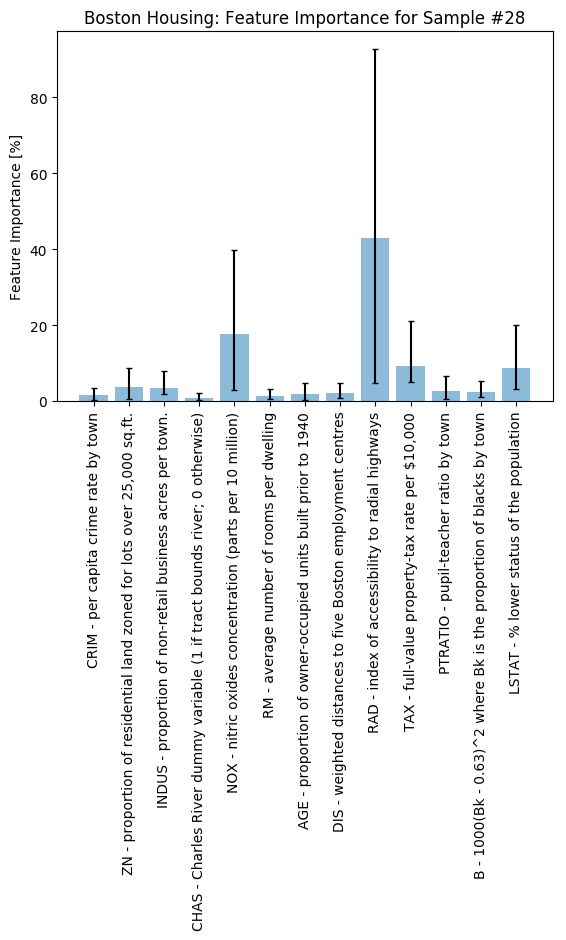

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from cxplain.visualisation.plot import Plot

plt.rcdefaults()

feature_names = TestUtil.get_boston_housing_feature_names()

np.random.seed(909)
selected_index = np.random.randint(len(x_test))
selected_sample = x_test[selected_index]
importances = attributions[selected_index]*100
importances_confidence = confidence[selected_index]*100

Plot.plot_attribution_1d(selected_sample, importances, importances_confidence,
                         title='Boston Housing: Feature Importance for Sample #{}'.format(selected_index),
                         feature_names=feature_names)